In [1]:
import xarray as xr
import numpy
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import scipy.io
import math
import json


Use ncclimo to generate regridded monthly time series for T, CLDICE, CLDLIQ and LANDFRAC needed for this analysis. 

eval ls v2.LR.historical_0101.eam.h0.*{2000..2014}*.nc | ncclimo -P eam --caseid=v2.LR.historical_0101 --var=T,CLDICE,CLDLIQ --yr_srt=2000 --yr_end=2014 --drc_out=/p/user_pub/e3sm/zhang40/COSP_phase_data -O /p/user_pub/e3sm/zhang40/COSP_phase_data/data --map=/p/user_pub/e3sm/staging/resource/maps/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc --split


In [2]:
def flatten_array(var):
    var_1d = var.stack(stacked=[...]).values
    var_1d = var_1d[~numpy.isnan(var_1d)]
    return var_1d

In [3]:
def compute_lcf(cice, cliq, temp):
    metrics_dict = {}
    ctot = cice + cliq
    ctot_sel = ctot.where((temp >= 220) & (temp <= 280)).where(ctot > 1e-9)
    cliq_sel = cliq.where(ctot_sel.notnull())
    temp_sel = temp.where(ctot_sel.notnull())
    
    ctot_1d = flatten_array(ctot_sel)
    cliq_1d = flatten_array(cliq_sel)
    temp_1d = flatten_array(temp_sel)
    
    lcf = cliq_1d/ctot_1d
    
    mean_stat = binned_statistic(temp_1d, lcf, 
                             statistic='mean', 
                             bins=20, 
                             range=(220, 280))
    
    temp_bin_center = (mean_stat.bin_edges[:-1] + mean_stat.bin_edges[1:]) / 2
    
    return temp_bin_center, mean_stat.statistic

In [4]:
datapath = '/p/user_pub/e3sm/zhang40/COSP_phase_data'
# TODO: add land masking
temp = xr.open_dataset(f'{datapath}/data/T_200001_201412.nc').isel(time=slice(0, 12)).sel(lat=slice(-70,-30))['T']
cice = xr.open_dataset(f'{datapath}/data/CLDICE_200001_201412.nc').isel(time=slice(0, 12)).sel(lat=slice(-70,-30))['CLDICE']
cliq = xr.open_dataset(f'{datapath}/data/CLDLIQ_200001_201412.nc').isel(time=slice(0, 12)).sel(lat=slice(-70,-30))['CLDLIQ']

In [5]:
metrics_dict = {}
metrics_dict['test'] = {}
metrics_dict['test']['T'], metrics_dict['test']['LCF']  = compute_lcf(cice, cliq, temp)

In [6]:
obs = []
for ibin, temp in enumerate(metrics_dict['test']['T']):
    temp = temp - 273.15
    pt=7.6725+1.0118*temp+0.1422*(temp**2)+0.0106*(temp**3)+3.39*1e-4*(temp**4)+3.95*1e-6*(temp**5)
    lcf = 1./(1.+math.exp(-1.*pt))
    obs.append(lcf)
metrics_dict['obs'] = {"T": metrics_dict['test']['T'],"LCF":obs}

In [7]:
# TODO add CMIP results.
cmip5 = scipy.io.loadmat(f'{datapath}/obs/SCL_T5050_30S_70S.mat')
cmip5_data = {}

for imod in range(len(cmip5['MODEL'][:])):
    model_name = cmip5['MODEL'][imod][0][0]
    cmip5_data[model_name]={}
    cmip5_data[model_name]['T']=cmip5['T'][imod][0].flatten()
    cmip5_data[model_name]['LCF']=cmip5['SCL'][imod][0].flatten()

metrics_dict['cmip5'] = cmip5_data


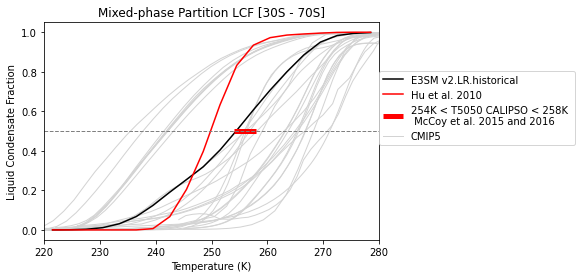

In [8]:
fig, ax = plt.subplots()

ax.plot(metrics_dict['test']['T'], metrics_dict['test']['LCF'], color = 'black', label='E3SM v2.LR.historical', zorder = 1)
ax.plot(metrics_dict['obs']['T'], metrics_dict['obs']['LCF'], color = 'red', label='Hu et al. 2010', zorder = 2)
ax.hlines(y=0.5, xmin=254, xmax=258, linewidth=5, color='r', label='254K < T5050 CALIPSO < 258K \n McCoy et al. 2015 and 2016')

for idx, imod in enumerate(list(metrics_dict['cmip5'].keys())):
    cmip5 = metrics_dict['cmip5']
    if idx == 0:
        ax.plot(cmip5[imod]['T'], cmip5[imod]['LCF'], linewidth=1, color = 'lightgrey', label='CMIP5', zorder = -1)
    else:
        ax.plot(cmip5[imod]['T'], cmip5[imod]['LCF'], linewidth=1, color = 'lightgrey', zorder = -1)#, label=cmip5['MODEL'][imod][0][0])

ax.hlines(y=0.5, xmin=220, xmax=280, linewidth=1, linestyles='--', color='grey')
ax.set_ylabel('Liquid Condensate Fraction')
ax.set_xlim(220,280)
ax.set_xlabel('Temperature (K)')
ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.8))
ax.set_title('Mixed-phase Partition LCF [30S - 70S]')
plt.show()

In [9]:
# Save reference data as a json file
metrics_dict['E3SM.v2.LR.historical']={}
metrics_dict['E3SM.v2.LR.historical']['T'] = metrics_dict['test']['T']
metrics_dict['E3SM.v2.LR.historical']['LCF'] = metrics_dict['test']['LCF']

del metrics_dict['test']
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open(f'{datapath}/mixed-phase_partition_data.json', 'w') as fp:
    json.dump(metrics_dict, fp, cls = NumpyEncoder)